# 1. Setup

## 1.2 Import Dependencies

In [1]:
!pip install tensorflow keras opencv-python matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from keras.api.models import Model
from keras.api.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import keras
import tensorflow as tf

## 1.4 Create Folder Structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [34]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [1]:
# http://vis-www.cs.umass.edu/lfw/

In [2]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [14]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3ddb601e-8d22-11ef-a650-10e7c63f298b.jpg'

In [6]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

KeyboardInterrupt: 

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

## 3.2 Preprocessing - Scale and Resize

In [8]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [9]:
anchor.as_numpy_iterator().next()

b'data\\anchor\\3dc36a9f-8b20-11ef-91c3-10e7c63f298b.jpg'

In [10]:
img = preprocess('data\\anchor\\0c2caea3-8b20-11ef-b25e-10e7c63f298b.jpg')

In [11]:
img.numpy().max() 

1.0

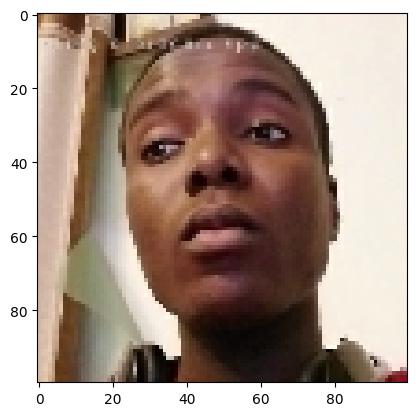

In [11]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [12]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [12]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

## 3.4 Build Train and Test Partition

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [15]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [16]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [17]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [14]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [15]:
embedding = make_embedding()

In [16]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [17]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_tensor = tf.convert_to_tensor(input_embedding)
        validation_tensor = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_tensor - validation_tensor)

## 4.3 Make Siamese Model

In [18]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [24]:
siamese_model = make_siamese_model()

In [26]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [19]:
binary_cross_loss = keras.losses.BinaryCrossentropy()

In [20]:
opt = keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

NameError: name 'siamese_model' is not defined

## 5.3 Build Train Step Function

In [30]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        
        # Squeeze yhat to remove extra dimensions
        yhat = tf.squeeze(yhat)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [31]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [32]:
EPOCHS = 50

In [125]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s

# 6. Evaluate Model

## 6.1 Import Metrics

In [33]:
# Import metric calculations
from keras.api.metrics import Precision, Recall

## 6.2 Make Predictions

In [34]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [35]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

C:\Users\Z240Home\PycharmProjects\face_recognition\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\Z240Home\PycharmProjects\face_recognition\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[[0.4998465 ],
        [0.5000682 ],
        [0.49976146],
        [0.50171244],
        [0.5001974 ],
        [0.49937457],
        [0.5001453 ],
        [0.49934012],
        [0.5010551 ],
        [0.49992463],
        [0.49900413],
        [0.4998409 ],
        [0.50072736],
        [0.50093687],
        [0.5009984 ],
        [0.5000107 ]]], dtype=float32)

In [36]:
[1 if pred > 0.5 else 0 for pred in y_hat.flatten()]

[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]

In [37]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [38]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.5833333

In [39]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.7777778

## 6.4 Viz Results

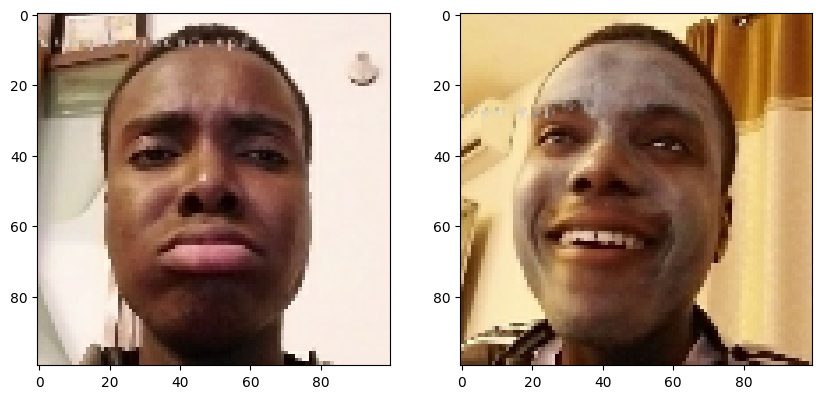

In [40]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

# 7. Save Model

In [40]:
# Save weights
siamese_model.save('siamesemodel.keras')

In [41]:
L1Dist

__main__.L1Dist

In [41]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [42]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[[2.7499681e-02],
        [5.6442656e-02],
        [6.0300375e-03],
        [9.9295396e-01],
        [3.7021765e-01],
        [1.9904833e-01],
        [1.8625116e-03],
        [1.0312492e-02],
        [5.3964391e-07],
        [4.4400182e-01],
        [9.9999070e-01],
        [9.2190212e-06],
        [9.9984521e-01],
        [4.4901983e-05],
        [2.2225140e-02],
        [6.1423178e-03]]], dtype=float32)

In [43]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [44]:
os.listdir(os.path.join('application_data', 'verification_images'))

['2e27f4b7-77ab-43a5-8851-32388138f1e7.jpg',
 '4db61102-125e-40e8-ae50-9e4d7dbd46ea.jpg',
 '5c029578-048a-4f00-a4ca-15a439e43513.jpg',
 '5df6d2fd-8b20-11ef-9d09-10e7c63f298b.jpg',
 '5e1f57ad-8b20-11ef-ba33-10e7c63f298b.jpg',
 '5e2b9521-382b-48da-9870-e268d8c7e7c4.jpg',
 '5e9d07d4-8b20-11ef-a5be-10e7c63f298b.jpg',
 '5fa27d9b-8b20-11ef-816a-10e7c63f298b.jpg',
 '5fc0fa43-8b20-11ef-8401-10e7c63f298b.jpg',
 '5ff883c5-8b20-11ef-8d5b-10e7c63f298b.jpg',
 '5ffc884f-42a8-4b12-9a52-3f7e1711c4a6.jpg',
 '6a3fb34e-8b20-11ef-8b24-10e7c63f298b.jpg',
 '6a46c6c4-8b20-11ef-835f-10e7c63f298b.jpg',
 '6a796143-8b20-11ef-8ed1-10e7c63f298b.jpg',
 '6a8e6c05-be9f-4d8b-93ba-1be0c5127261.jpg',
 '6aba8e5b-8b20-11ef-9120-10e7c63f298b.jpg',
 '6ae7f6d2-8b20-11ef-82ed-10e7c63f298b.jpg',
 '6b107bba-8b20-11ef-aaac-10e7c63f298b.jpg',
 '6b478edf-8b20-11ef-9d31-10e7c63f298b.jpg',
 '6b4c6f9d-8b20-11ef-b6f9-10e7c63f298b.jpg',
 '6b5af9cf-f6e9-4181-964a-95b1191ae969.jpg',
 '6ba77954-8b20-11ef-8988-10e7c63f298b.jpg',
 '6bd82056

In [45]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [46]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\2e27f4b7-77ab-43a5-8851-32388138f1e7.jpg
application_data\verification_images\4db61102-125e-40e8-ae50-9e4d7dbd46ea.jpg
application_data\verification_images\5c029578-048a-4f00-a4ca-15a439e43513.jpg
application_data\verification_images\5df6d2fd-8b20-11ef-9d09-10e7c63f298b.jpg
application_data\verification_images\5e1f57ad-8b20-11ef-ba33-10e7c63f298b.jpg
application_data\verification_images\5e2b9521-382b-48da-9870-e268d8c7e7c4.jpg
application_data\verification_images\5e9d07d4-8b20-11ef-a5be-10e7c63f298b.jpg
application_data\verification_images\5fa27d9b-8b20-11ef-816a-10e7c63f298b.jpg
application_data\verification_images\5fc0fa43-8b20-11ef-8401-10e7c63f298b.jpg
application_data\verification_images\5ff883c5-8b20-11ef-8d5b-10e7c63f298b.jpg
application_data\verification_images\5ffc884f-42a8-4b12-9a52-3f7e1711c4a6.jpg
application_data\verification_images\6a3fb34e-8b20-11ef-8b24-10e7c63f298b.jpg
application_data\verification_images\6a46c6c4-8b20-11ef-835f-10e

In [47]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [61]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━

In [62]:
np.sum(np.squeeze(results) > 0.9)

28

In [64]:
28/340

0.08235294117647059